In [42]:
import pandas as pd

# Load the dataset
data = pd.read_csv('./Solar Power Plant Data.csv')

# Summarize key statistics for each variable
statistics_summary = data.describe()
print("\nStatistics Summary:\n", statistics_summary)
# Display the first few rows of the dataset
data.head()


Statistics Summary:
          WindSpeed     Sunshine  AirPressure    Radiation  AirTemperature  \
count  8760.000000  8760.000000  8760.000000  8760.000000     8760.000000   
mean      2.639823    11.180479  1010.361781    97.538493        6.978893   
std       1.628754    21.171295    12.793971   182.336029        7.604266   
min       0.000000     0.000000   965.900000    -9.300000      -12.400000   
25%       1.400000     0.000000  1002.800000    -6.200000        0.500000   
50%       2.300000     0.000000  1011.000000    -1.400000        6.400000   
75%       3.600000     7.000000  1018.200000   115.600000       13.400000   
max      10.900000    60.000000  1047.300000   899.700000       27.100000   

       RelativeAirHumidity  SystemProduction  
count          8760.000000       8760.000000  
mean             76.719406        684.746071  
std              19.278996       1487.454665  
min              13.000000          0.000000  
25%              64.000000          0.000000  
50

,Date-Hour(NMT),WindSpeed,Sunshine,AirPressure,Radiation,AirTemperature,RelativeAirHumidity,SystemProduction
0,01.01.2017-00:00,0.6,0,1003.8,-7.4,0.1,97,0.0
1,01.01.2017-01:00,1.7,0,1003.5,-7.4,-0.2,98,0.0
2,01.01.2017-02:00,0.6,0,1003.4,-6.7,-1.2,99,0.0
3,01.01.2017-03:00,2.4,0,1003.3,-7.2,-1.3,99,0.0
4,01.01.2017-04:00,4.0,0,1003.1,-6.3,3.6,67,0.0


In [43]:
# Drop the columns that are not required
columns_to_keep = ['Date-Hour(NMT)', 'SystemProduction']
columns_to_drop = [col for col in data.columns if col not in columns_to_keep]
data = data.drop(columns_to_drop, axis=1)

# Check for missing values in the dataset
missing_values = data.isnull().sum()
print("Missing values in each column:\n", missing_values)

# Reformating the date column taking only the hour
data['Date-Hour(NMT)'] = pd.to_datetime(data['Date-Hour(NMT)'], format='%d.%m.%Y-%H:%M')
data['Month'] = data['Date-Hour(NMT)'].dt.month
data['Day'] = data['Date-Hour(NMT)'].dt.day
data['Hour'] = data['Date-Hour(NMT)'].dt.hour
data.head()

Missing values in each column:
 Date-Hour(NMT)      0
SystemProduction    0
dtype: int64


,Date-Hour(NMT),SystemProduction,Month,Day,Hour
0,2017-01-01 00:00:00,0.0,1,1,0
1,2017-01-01 01:00:00,0.0,1,1,1
2,2017-01-01 02:00:00,0.0,1,1,2
3,2017-01-01 03:00:00,0.0,1,1,3
4,2017-01-01 04:00:00,0.0,1,1,4


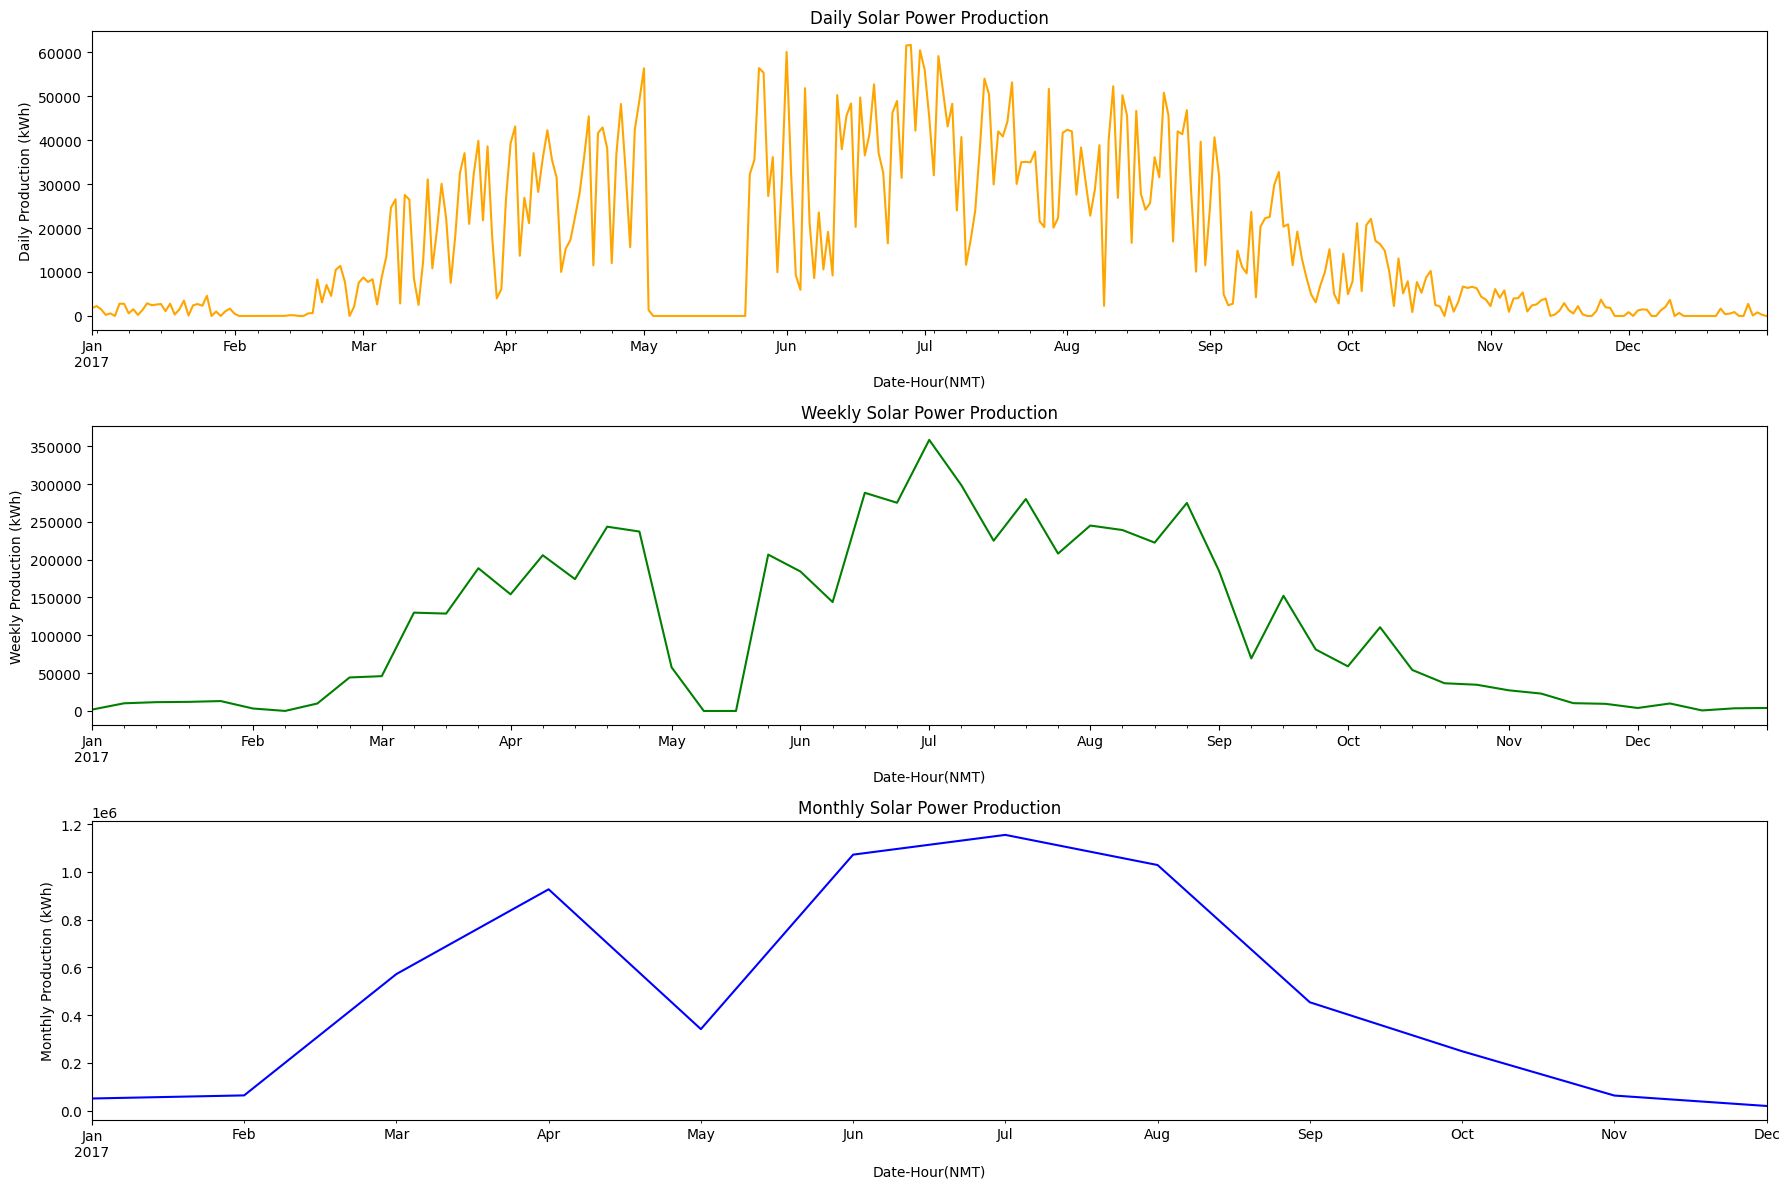

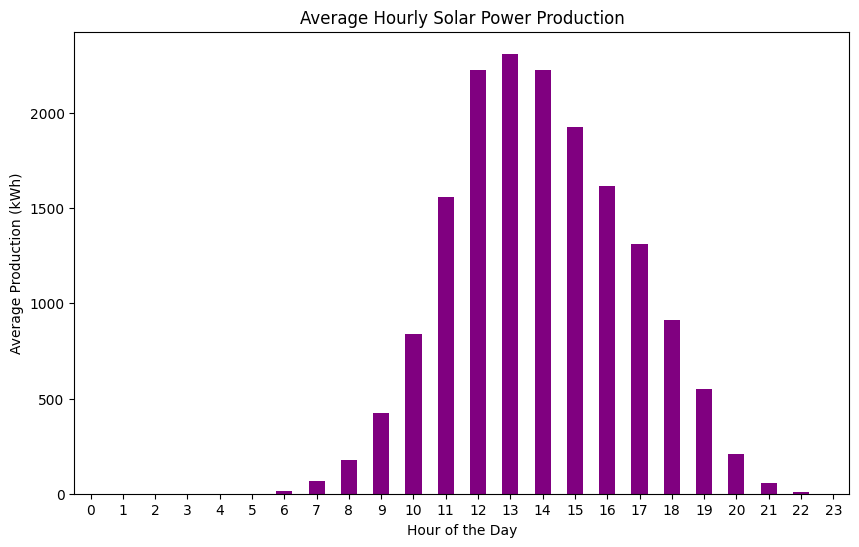

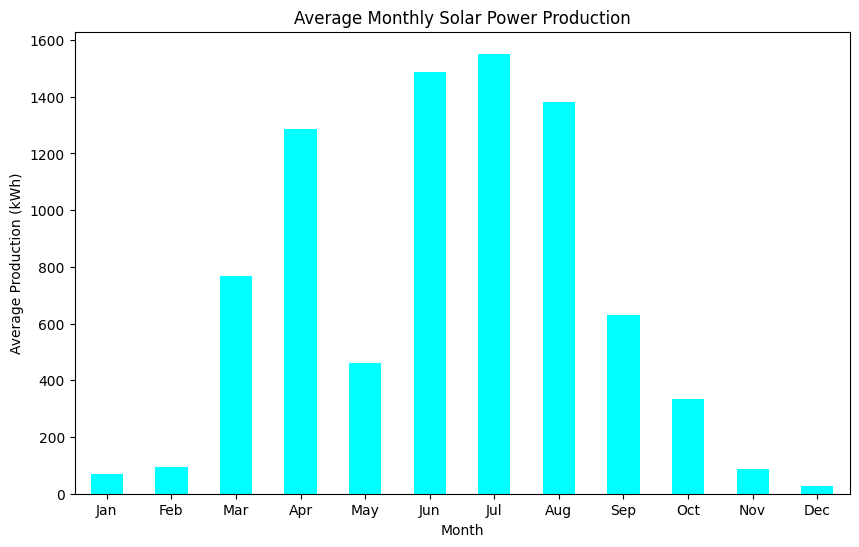

In [44]:
import matplotlib.pyplot as plt
import numpy as np
# Set 'Date-Hour(NMT)' as the index of the dataframe
data.set_index('Date-Hour(NMT)', inplace=True)
# Resampling data to daily, weekly, and monthly averages to observe different trends
daily_production = data['SystemProduction'].resample('D').sum()
weekly_production = data['SystemProduction'].resample('W').sum()
monthly_production = data['SystemProduction'].resample('ME').sum()

# Plotting the resampled data
plt.figure(figsize=(18, 12))

plt.subplot(3, 1, 1)
daily_production.plot(title='Daily Solar Power Production', color='orange')
plt.ylabel('Daily Production (kWh)')

plt.subplot(3, 1, 2)
weekly_production.plot(title='Weekly Solar Power Production', color='green')
plt.ylabel('Weekly Production (kWh)')

plt.subplot(3, 1, 3)
monthly_production.plot(title='Monthly Solar Power Production', color='blue')
plt.ylabel('Monthly Production (kWh)')

plt.tight_layout()
plt.show()

# Analyzing production by hour of the day
hourly_means = data['SystemProduction'].groupby(data.index.hour).mean()

plt.figure(figsize=(10, 6))
hourly_means.plot(kind='bar', color='purple')
plt.title('Average Hourly Solar Power Production')
plt.xlabel('Hour of the Day')
plt.ylabel('Average Production (kWh)')
plt.xticks(rotation=0)
plt.show()

# Seasonal analysis of solar power production
data['Month'] = data.index.month
seasonal_means = data['SystemProduction'].groupby(data['Month']).mean()

plt.figure(figsize=(10, 6))
seasonal_means.plot(kind='bar', color='cyan')
plt.title('Average Monthly Solar Power Production')
plt.xlabel('Month')
plt.ylabel('Average Production (kWh)')
plt.xticks(ticks=np.arange(12), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], rotation=0)
plt.show()

In [45]:
# removing the data points where the system production is zero
data = data[data['Hour'].between(6, 22)]
data = data[data['SystemProduction'] != 0]

In [46]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, f1_score
from sklearn.preprocessing import StandardScaler

# Prepare the data for modeling
x = data[['Month', 'Day', 'Hour']]
y = data['SystemProduction']

# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

# Initialize and train the RandomForestRegressor
model = RandomForestRegressor(n_estimators=50, random_state=42)
model.fit(x_train_scaled, y_train)

# Predict on the test set
y_pred = model.predict(x_test_scaled)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse:.2f}")
print(f"R^2 Score: {r2:.2f}")

Mean Squared Error: 1042533.80
R^2 Score: 0.73


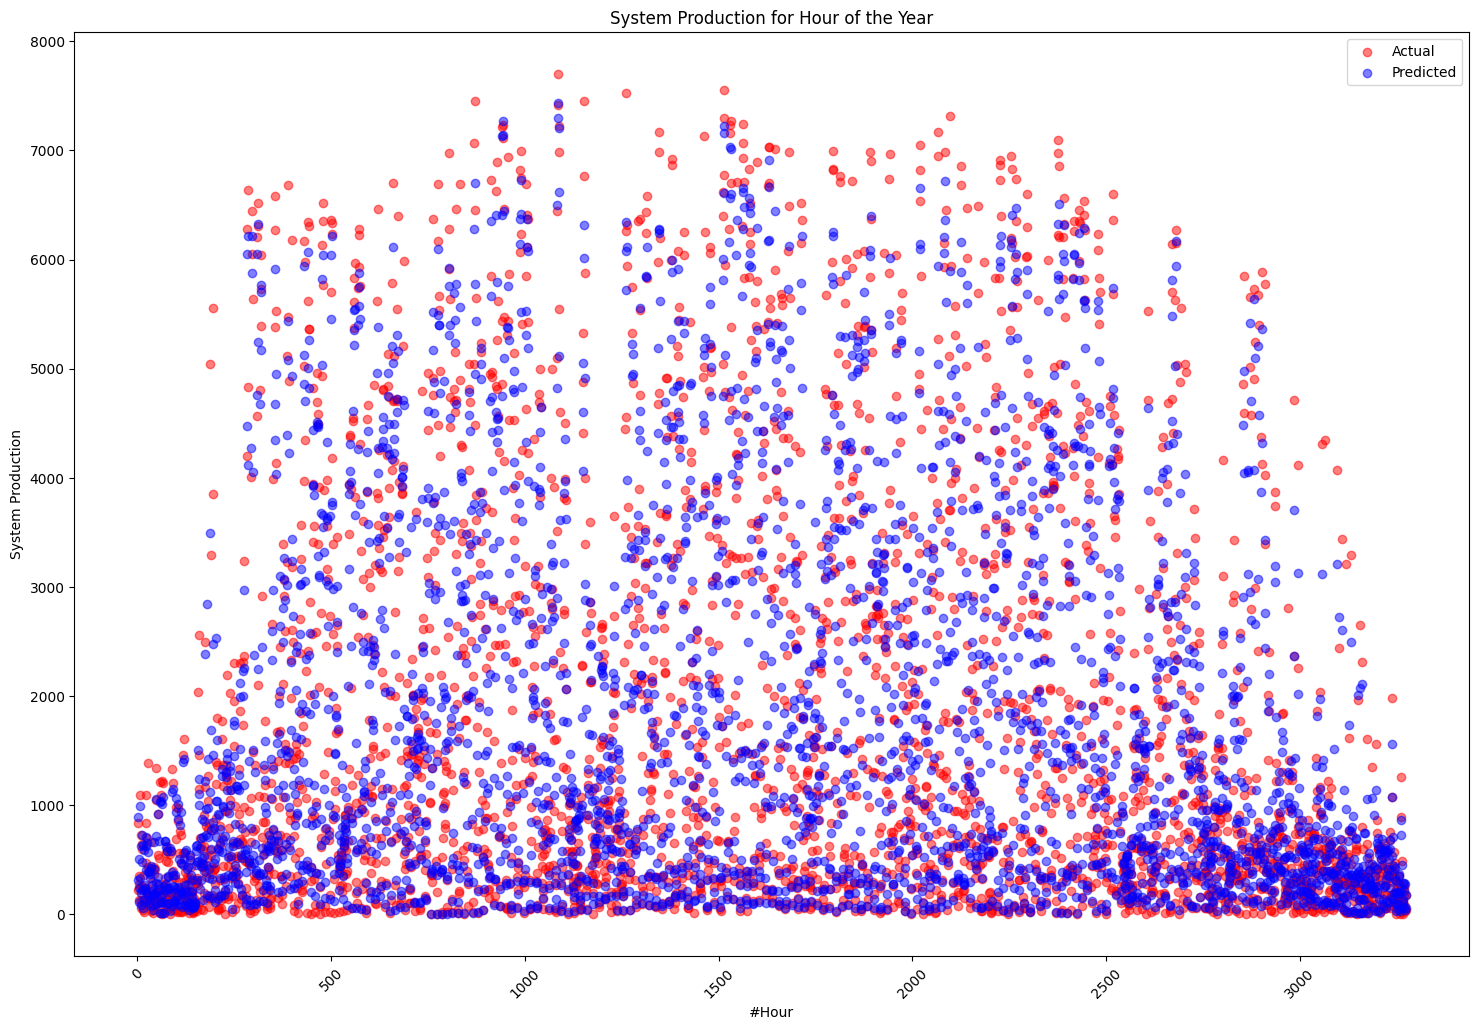

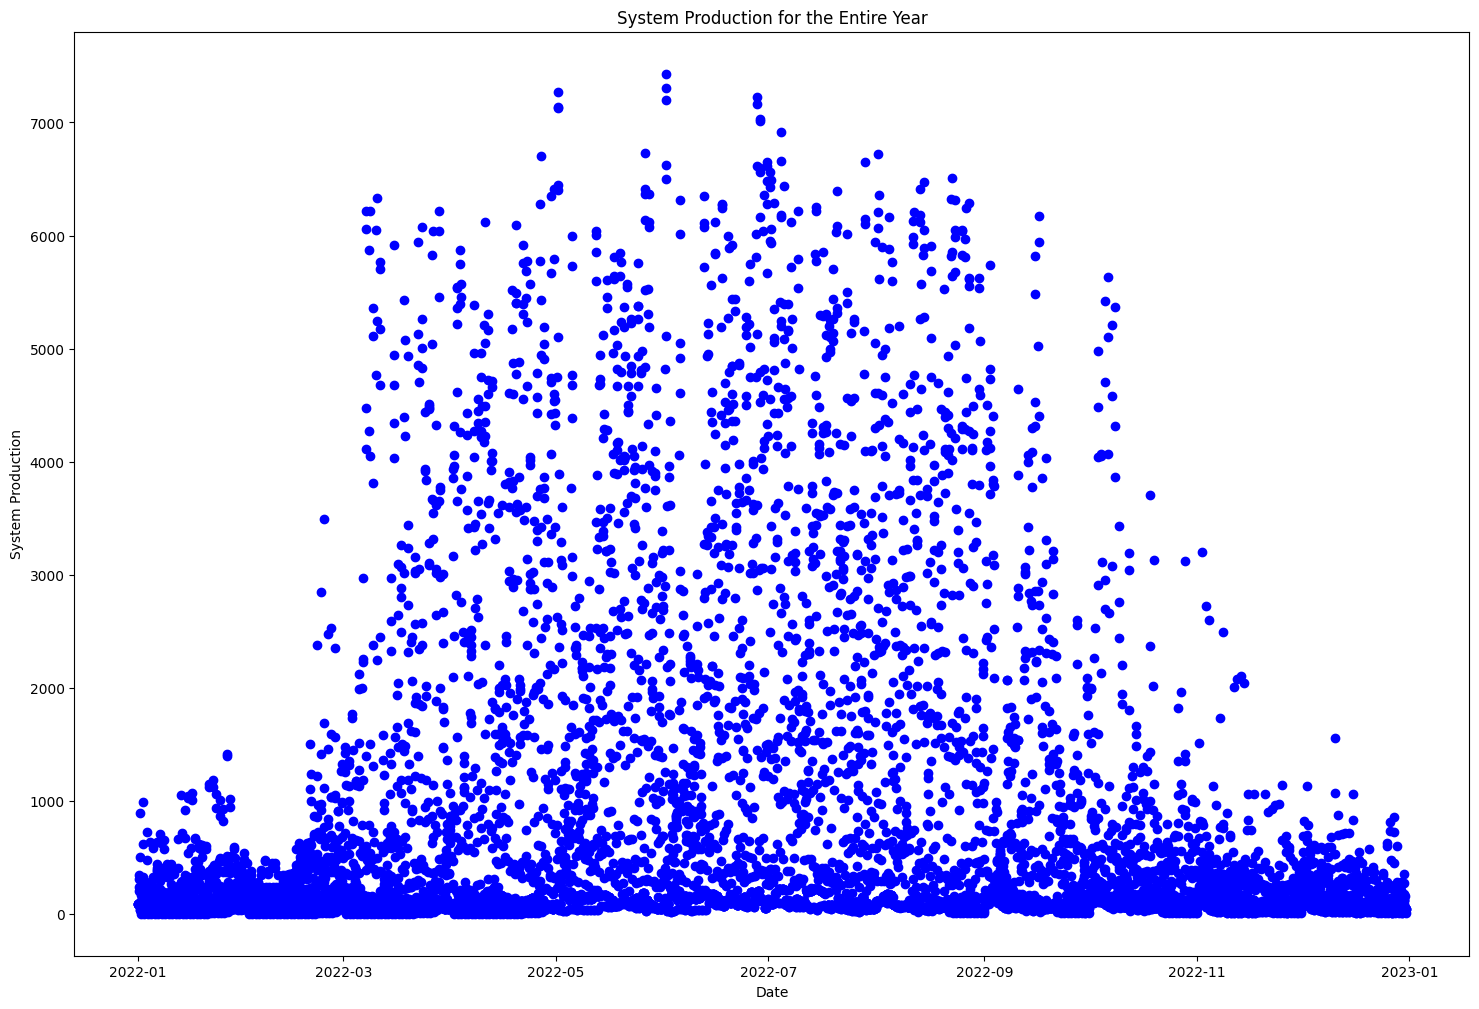

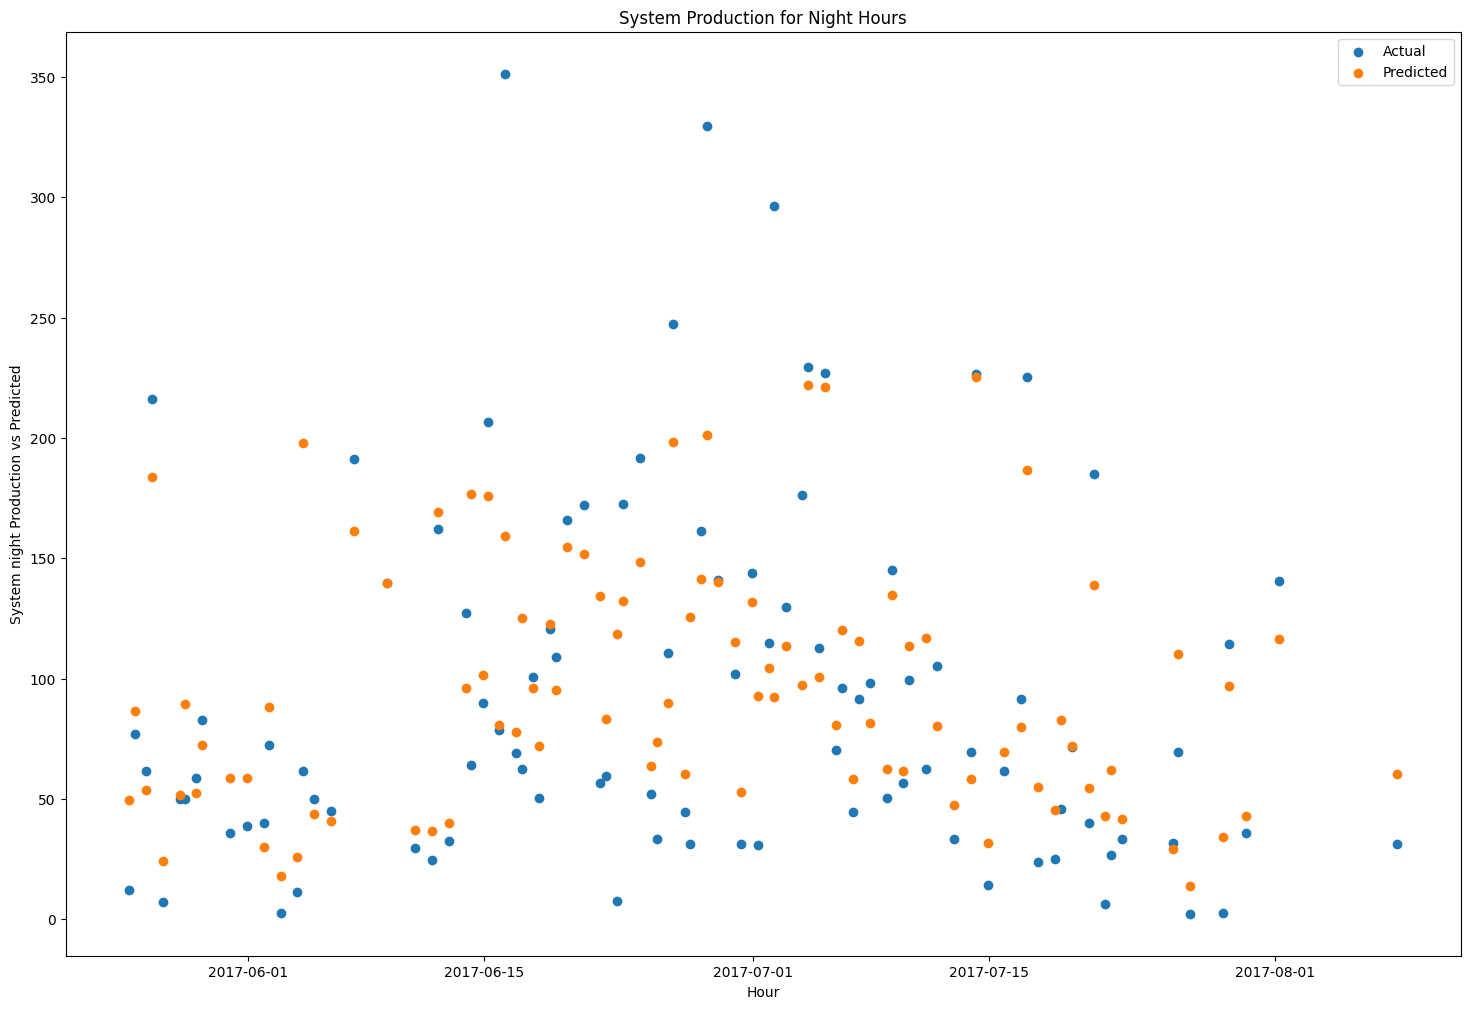

Mean Squared Error: 2137.58
R^2 Score: 0.61


In [47]:
# Plot the actual vs predicted values
plt.figure(figsize=(18, 12))
# Create a scatter plot
#plt.plot(dates, y)
x_real = list(range(1, data[['Month', 'Day', 'Hour']].shape[0]+1))
y_pred = model.predict(scaler.transform(data[['Month', 'Day', 'Hour']]))

plt.scatter(x_real, data['SystemProduction'], color='red', alpha=0.5)
plt.scatter(x_real, y_pred, color='blue', alpha=0.5)
# Set the labels and title
plt.xlabel('#Hour')
plt.ylabel('System Production')
plt.title('System Production for Hour of the Year')
plt.legend(['Actual', 'Predicted'])
# Rotate the x-axis labels for better visibility
plt.xticks(rotation=45)

# Display the plot
plt.show()

# Plot the predictions for the entire year
plt.figure(figsize=(18, 12))
# Dates for the entire year
start_date = pd.to_datetime('2022-01-01')
end_date = pd.to_datetime('2022-12-31')
dates = pd.date_range(start_date, end_date, freq='h')
x_all_year = pd.DataFrame({'Month': dates.month, 'Day': dates.day, 'Hour': dates.hour})

y_all_year = model.predict(scaler.transform(x_all_year))

plt.scatter(dates, y_all_year, color='blue')
plt.xlabel('Date')
plt.ylabel('System Production')
plt.title('System Production for the Entire Year')
plt.show()

plt.figure(figsize=(18, 12))
night_data = data[data['Hour'].isin([0, 1, 2, 3, 4, 5, 6, 22, 23])]
plt.scatter(x=night_data.index, y=night_data['SystemProduction'])
pred_night_data = model.predict(scaler.transform(night_data[['Month', 'Day', 'Hour']]))
plt.scatter(x=night_data.index, y=pred_night_data)
plt.xlabel('Hour')
plt.ylabel('System night Production vs Predicted')
plt.title('System Production for Night Hours')
plt.legend(['Actual', 'Predicted'])
plt.show()
# Evaluate night time predictions
mse = mean_squared_error(night_data['SystemProduction'], pred_night_data)
r2 = r2_score(night_data['SystemProduction'], pred_night_data)

print(f"Mean Squared Error: {mse:.2f}")
print(f"R^2 Score: {r2:.2f}")


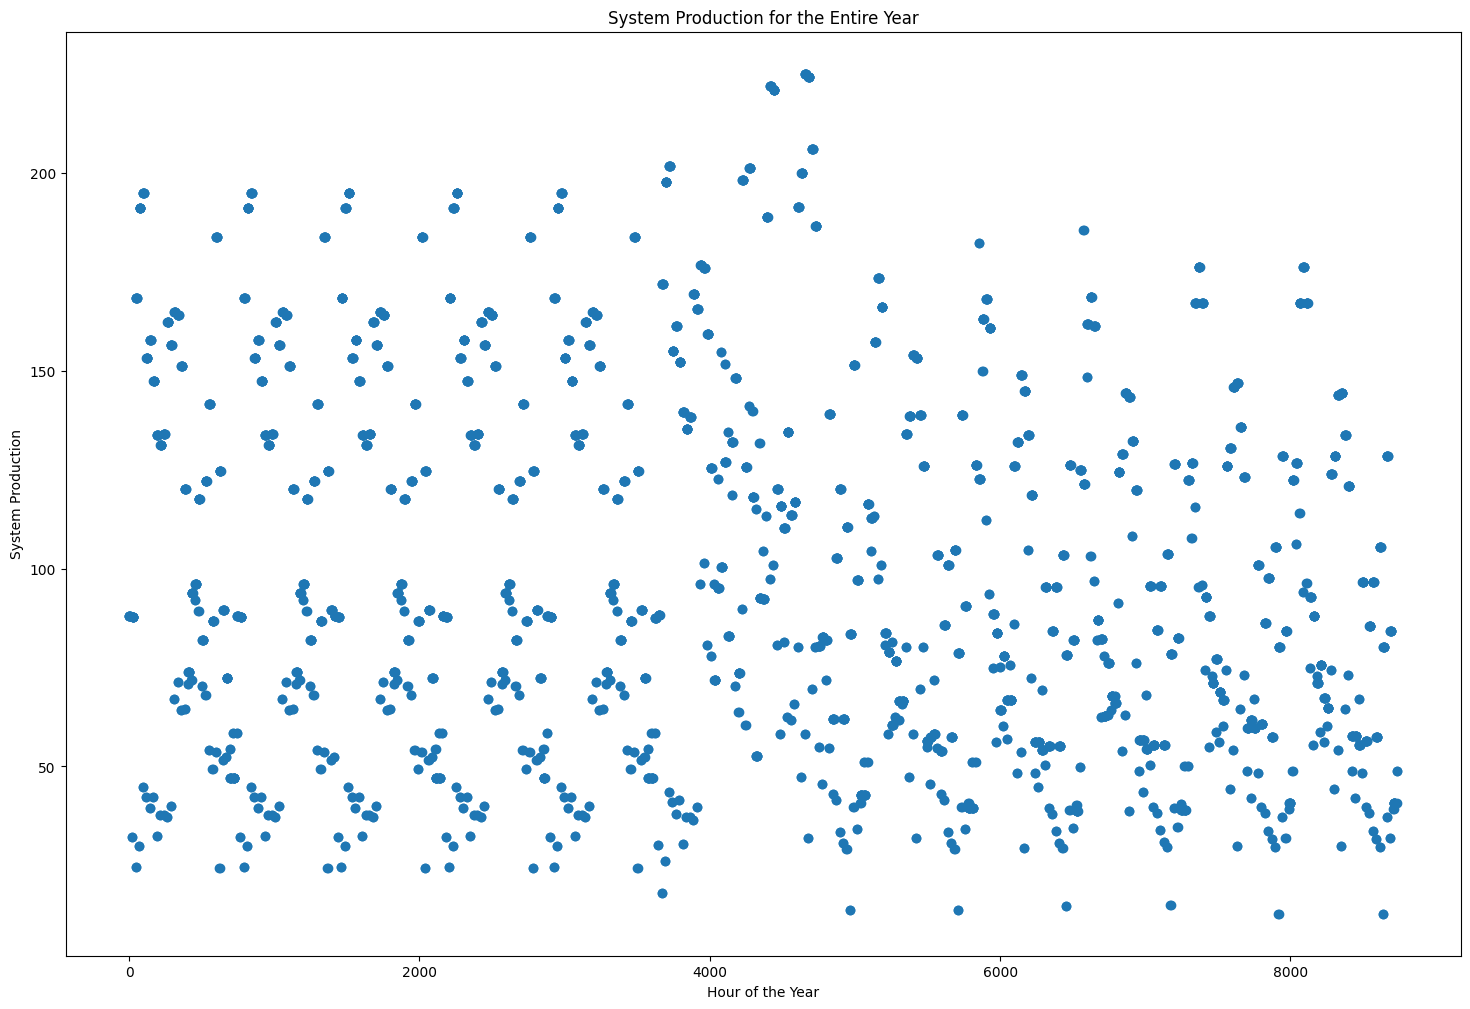

In [52]:
# Visualize the system production prediction for only night time hours
x_only_night = x_all_year[x_all_year['Hour'].between(22, 23) | x_all_year['Hour'].between(0, 6)]
y_only_night = model.predict(scaler.transform(x_only_night))

plt.figure(figsize=(18, 12))
plt.scatter(x_only_night.index, y_only_night)
plt.xlabel('Hour of the Year')
plt.ylabel('System Production')
plt.title('System Production for the Entire Year')
plt.show()



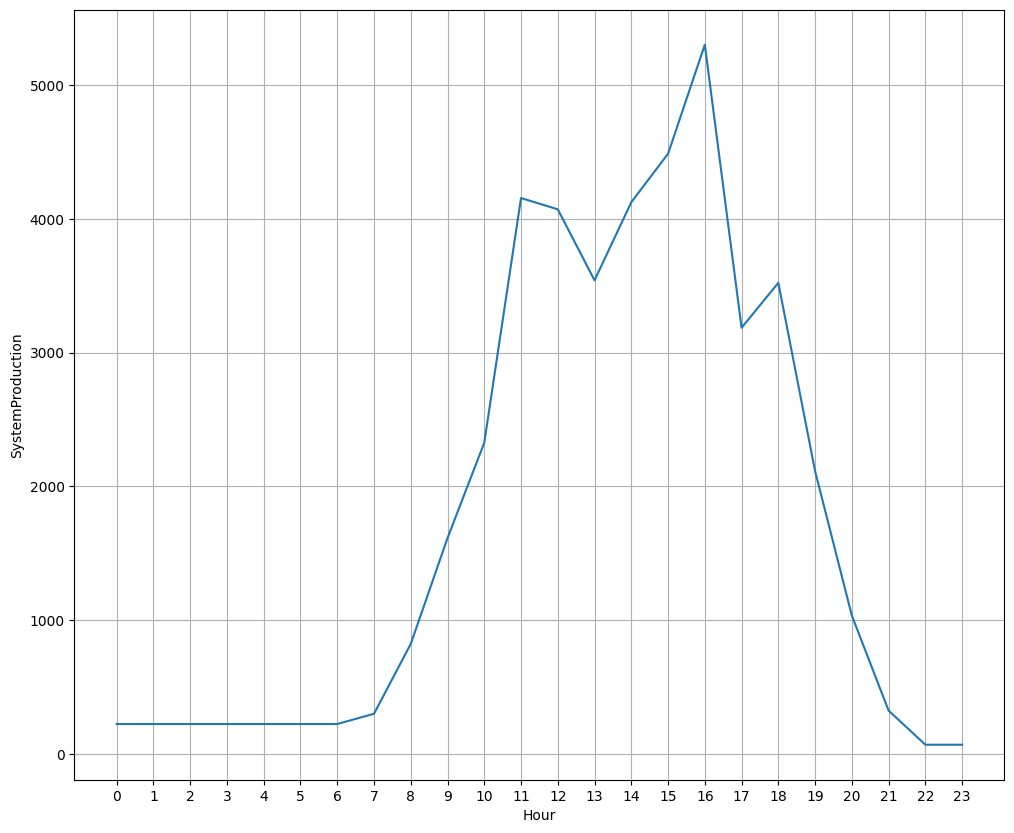

In [63]:
import matplotlib.pyplot as plt
# Select a specific date to plot
Date = [7,15]
# Plot the SystemProduction for each hour of the day
selected_day = x_all_year[(x_all_year['Month'] == Date[0]) & (x_all_year['Day'] == Date[1])]
plt.figure(figsize=(12, 10))
plt.plot(selected_day['Hour'], y_all_year[selected_day.index])
plt.grid()
plt.xticks(range(24))
plt.xlabel('Hour')
plt.ylabel('SystemProduction')
plt.show()

In [50]:
#import emlearn

# convert the model to C code for use in IoT devices
path = './solar_prediction.h'
#cmodel = emlearn.convert(model, method='inline')
#cmodel.save(file=path, name='solar_prediction')

print('Wrote model to', path)

Wrote model to ./solar_prediction.h
